# Bonus Sensitivity Analysis

This notebook models how varying bonus percentages impact user conversion, lifetime value (LTV), and gross margin. Synthetic data is generated to illustrate the trade-offs between growth and profitability.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-muted')

## 1. Generate synthetic bonus and performance data

In [4]:
rng = np.random.default_rng(42)

bonus_pct = np.linspace(0, 0.50, 21)  # 0% to 50% in 2.5% increments

# Model conversion rate: base 8% with diminishing returns
base_conversion = 0.08
conv_sensitivity = 0.35
user_conversion_rate = base_conversion * (1 + conv_sensitivity * np.sqrt(bonus_pct))

# Model average LTV: base $120 with bonus-driven uplift and diminishing returns
base_ltv = 120
ltv_uplift = 0.9
average_ltv = base_ltv * (1 + ltv_uplift * (1 - np.exp(-4 * bonus_pct)))

# Model gross margin: base 55% reduced by bonus costs and higher engagement costs
base_margin = 0.55
margin_drag = 0.6
gross_margin = base_margin - margin_drag * bonus_pct

# Clip to realistic ranges
user_conversion_rate = np.clip(user_conversion_rate, 0, 0.35)
gross_margin = np.clip(gross_margin, 0.1, None)

data = pd.DataFrame({
    'bonus_pct': bonus_pct,
    'user_conversion_rate': user_conversion_rate,
    'average_LTV': average_ltv,
    'gross_margin': gross_margin
})

data.head()

,bonus_pct,user_conversion_rate,average_LTV,gross_margin
0,0.000,0.080000,120.000000,0.550
1,0.025,0.084427,130.277559,0.535
2,0.050,0.086261,139.577079,0.520
3,0.075,0.087668,147.991632,0.505
4,0.100,0.088854,155.605435,0.490


## 2. Estimate elasticity and visualize

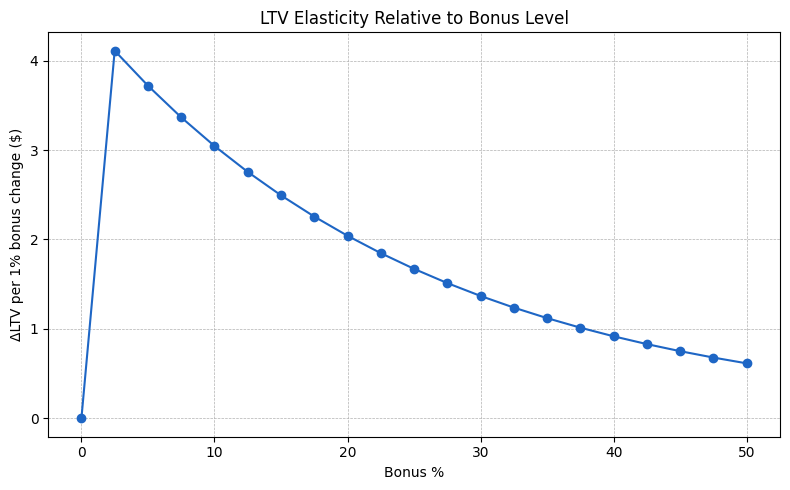

In [6]:
# --- Compute LTV Elasticity and Save Chart ---
from pathlib import Path

# Ensure directory exists
Path("bonus_sensitivity_model").mkdir(parents=True, exist_ok=True)

# Calculate elasticity: change in LTV per 1 percentage point change in bonus
bonus_pct_points = data['bonus_pct'] * 100
ltv = data['average_LTV']

ltv_diff = ltv.diff()
bonus_diff = bonus_pct_points.diff()
ltv_elasticity = (ltv_diff / bonus_diff).fillna(0)

# Store elasticity in dataframe
data['ltv_elasticity_per_pct'] = ltv_elasticity

# Plot elasticity curve
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(data['bonus_pct'] * 100, data['ltv_elasticity_per_pct'], marker='o', color='#1E66C5')
ax.set_xlabel('Bonus %')
ax.set_ylabel('ΔLTV per 1% bonus change ($)')
ax.set_title('LTV Elasticity Relative to Bonus Level')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('bonus_sensitivity_model/ltv_elasticity.png', dpi=150)
plt.show()

## 3. Evaluate growth vs. profitability trade-off

In [7]:
# Compute expected contribution margin per acquired user
expected_revenue = data['user_conversion_rate'] * data['average_LTV']
contribution_margin = expected_revenue * data['gross_margin']

summary_table = data.assign(
    expected_revenue=expected_revenue,
    contribution_margin=contribution_margin
)

summary_table.round({
    'bonus_pct': 3,
    'user_conversion_rate': 3,
    'average_LTV': 2,
    'gross_margin': 3,
    'ltv_elasticity_per_pct': 2,
    'expected_revenue': 2,
    'contribution_margin': 2
})

,bonus_pct,user_conversion_rate,average_LTV,gross_margin,ltv_elasticity_per_pct,expected_revenue,contribution_margin
0,0.000,0.080,120.00,0.550,0.00,9.60,5.28
1,0.025,0.084,130.28,0.535,4.11,11.00,5.88
2,0.050,0.086,139.58,0.520,3.72,12.04,6.26
3,0.075,0.088,147.99,0.505,3.37,12.97,6.55
4,0.100,0.089,155.61,0.490,3.05,13.83,6.77
5,0.125,0.090,162.49,0.475,2.76,14.61,6.94
6,0.150,0.091,168.73,0.460,2.49,15.33,7.05
7,0.175,0.092,174.37,0.445,2.26,15.99,7.12
8,0.200,0.093,179.47,0.430,2.04,16.61,7.14
9,0.225,0.093,184.09,0.415,1.85,17.17,7.13


In [8]:
# Save outputs
summary_table.to_csv('bonus_sensitivity_model/bonus_sensitivity_data.csv', index=False)
summary_table.head()

,bonus_pct,user_conversion_rate,average_LTV,gross_margin,ltv_elasticity_per_pct,expected_revenue,contribution_margin
0,0.000,0.080000,120.000000,0.550,0.000000,9.600000,5.280000
1,0.025,0.084427,130.277559,0.535,4.111024,10.998968,5.884448
2,0.050,0.086261,139.577079,0.520,3.719808,12.040057,6.260830
3,0.075,0.087668,147.991632,0.505,3.365821,12.974148,6.551945
4,0.100,0.088854,155.605435,0.490,3.045521,13.826224,6.774850


The CSV file (`bonus_sensitivity_data.csv`) and elasticity chart (`ltv_elasticity.png`) are saved in the `bonus_sensitivity_model` directory for reference.